In [3]:
import pandas as pd

In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB, quicksum
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

In [2]:
df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11987
1,0.11719
2,0.11368
3,0.11192
4,0.10939


In [5]:
# Preparation:


df_p.index = df["date"].values[:8760]
df_p.index = pd.to_datetime(df_p.index)
df_p["Hour"] = df_p.index.hour
df_p["Charging Allowed"] = df_p["Hour"].apply(lambda x: 1 if (x<9 or x>19) else 0)

df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)


# load household config
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")


def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

df_results = pd.DataFrame()
df_results.index = df_p.index


In [62]:
# model settings


for idx_initial, household in household_config.iloc[:1].iterrows():
    hp_load = df_hp[household["heat_pump_profile"]]
    hh_load = df_hh[household["household_profile"]]
    ev_load = df_hh[household["household_profile"]]
    pv_size = household["pv_power"]
    bess_size = household["bess_capacity"]
    max_bess_power = household["bess_power"]

    dynamic_prices = True
    dynamic_operation = True

    # Initialize your environment and model
    env = gp.Env(empty=True)
    env.setParam("OutputFlag", 1)
    env.start()
    model = gp.Model("test", env=env)
    model.setParam('MIPGap', 0.001) 
    # Determine length and prices, multiply ev and pv times 1000 to bring ev
    length = len(df_p)
    days = int(length/24)

    # either set prices dynamically or static as average wholesale price
    if dynamic_prices:
        prices = df_p["Deutschland/Luxemburg [€/kWh]"].values
    else:
        average_price = df_p["Deutschland/Luxemburg [€/kWh]"].mean()
        prices = np.full(length, average_price)


    real_ev_charging = ev_load.apply(lambda x:x/1000).values
    max_ev_charging = max(real_ev_charging)/2
    allowed_charging_hours = df_p["Charging Allowed"].values

    pv_size = bess_size
    pv_load = df_pv["electricity"].apply(lambda x: x*pv_size).values
    min_bess_energy = 0.05*bess_size
    feed_in_tariff = 0.07

    # transform hh and hp load to kW
    real_hh_load = hh_load.apply(lambda x:x/1000).values
    real_hp_load = hp_load.apply(lambda x:x/1000).values
    max_hp_load = real_hp_load.max()

    # Initialize variables
    if dynamic_operation:
        opt_ev_charging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_ch_opt")
        opt_hp_load = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_hp_opt")
    opt_bess_charging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_bess_ch_opt")
    opt_bess_discharging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_bess_dch_opt")
    opt_net_energy = model.addVars([t for t in range(length)],lb=-1e20, vtype=GRB.CONTINUOUS,name="opt_net_energy")
    buy_energy = model.addVars(length, vtype=GRB.BINARY, name="buy_energy") # positive when grid intake, zero when feed-out
    e_bess = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="e_bess")


    energy_costs = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "energy_costs")
    feedin_profits = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "feedin_profits")

    opt_feed_out_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_feed_out_pv")
    opt_internaluse_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_internaluse_pv")


    block_hp = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name = "blocked_heatpump")


    #### ELECTRIC VEHICLE
    # Ensure that daily charging requirements are met

    if dynamic_operation:
        for idx in range(days):
            idx_start = idx*24
            idx_end = (idx+1)*24
            model.addConstr(quicksum(opt_ev_charging[t]*allowed_charging_hours[t] for t in range(idx_start, idx_end)) == quicksum(real_ev_charging[t] for t in range(idx_start, idx_end)),"daily_charge")


        # Ensure maximum empirical EV charging is never exceeded
        model.addConstrs(opt_ev_charging[t] <= max_ev_charging for t in range(length))

        # Only charging in allowed hours
        model.addConstrs((opt_ev_charging[t] == 0 for t in range(length) if allowed_charging_hours[t] == 0), "no_charging_when_disallowed")


    #### HEAT PUMP
    # ensure maximum three blocking windows and unblocking for two hours after blocking

    if dynamic_operation:

        for idx in range(days):
            idx_start = idx * 24
            idx_end = (idx + 1) * 24

            # Constraint for maximum three blocks of two hours
            two_hour_blocks = 0
            for t in range(idx_start, idx_end - 1):
                if t < idx_end - 3:
                    two_hour_blocks += model.addVar(vtype=GRB.BINARY)
                    model.addConstr(two_hour_blocks >= block_hp[t] + block_hp[t + 1] - 1)

                    # At least two hours unblock after each block
                    model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp[t + 2]))
                    model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp[t + 3]))

            model.addConstr(two_hour_blocks <= 3, "max_three_blocks_{}".format(idx))

        # ensure that maximum empirical heat pump load is never exceeded and in non-blocking hours at least empirical load
        for t in range(length):
            model.addConstr(opt_hp_load[t]<=max_hp_load)
            model.addConstr((opt_hp_load[t]>=(1-block_hp[t])*real_hp_load[t]))

        # ensure that the daily heat demand is covered
        for idx in range(days):
            idx_start = idx*24
            idx_end = (idx+1)*24
            model.addConstr(quicksum((1-block_hp[t])*opt_hp_load[t] for t in range(idx_start, idx_end)) >= quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))


        # ensure that the sum of heat pump load every 6 hours remains in the same range
        for idx in range(days * 4):
            idx_start = idx * 6
            idx_end = (idx + 1) * 6
            if idx_end > length:
                idx_end = length  # Ensure we don't exceed the bounds
            model.addConstr(quicksum(opt_hp_load[t] for t in range(idx_start, idx_end)) >= quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))


    #### BATTERY STORAGE
    model.addConstr(e_bess[0]==min_bess_energy)

    for t in range(length):
        model.addConstr(opt_bess_charging[t] * opt_bess_discharging[t] == 0, "mutual_exclusivity_" + str(t))
        model.addConstr(opt_bess_charging[t]<=max_bess_power)
        model.addConstr(opt_bess_discharging[t]<=max_bess_power)
        model.addConstr(opt_bess_charging[t]<=pv_load[t])


    for t in range(1, length):
        model.addConstr(e_bess[t]==e_bess[t-1]+opt_bess_charging[t-1]-opt_bess_discharging[t-1])
        model.addConstr(e_bess[t]>=min_bess_energy)
        model.addConstr(e_bess[t]<=bess_size)

    ### OPTI
    # calculate net energy of household
    if dynamic_operation:
        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+opt_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
    else:
        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+real_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t])for t in range(length))

    '''
    for t in range(length):
        model.addConstr(opt_feed_out_pv[t]<=pv_load[t]-opt_net_energy[t])
    # set buy energy
    for t in range(length):
        model.addConstr(opt_feed_out_pv[t]==pv_load[t]-opt_net_energy[t])
        # If buy_energy[t] is 1 (buying energy), then opt_net_energy[t] must be positive
        model.addGenConstrIndicator(buy_energy[t], True, opt_net_energy[t] >= 0.1, name="link_positive_" + str(t))
        # If buy_energy[t] is 0 (selling energy), then opt_net_energy[t] must be non-positive
        model.addGenConstrIndicator(buy_energy[t], False, opt_net_energy[t] <= 0.1, name="link_negative_" + str(t))
    '''
    # energy costs
    for t in range(length):
        model.addConstr((opt_internaluse_pv[t]+opt_feed_out_pv[t])==pv_load[t])
        model.addConstr(energy_costs[t] == ((opt_net_energy[t]) * prices[t] ), "calc_energy_costs_" + str(t))
        model.addConstr(feedin_profits[t] == opt_feed_out_pv[t]*feed_in_tariff, "calc_energy_profits_" + str(t))

        # final optimize

    model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length)), GRB.MINIMIZE)
    model.optimize()




    vn = ["opt_net_energy","energy_costs","p_ch_opt","p_hp_opt","blocked_heatpump","p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","e_bess"] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
    n = length
    temp_results = get_results_in_df(model, vn, n)
    df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


    


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 143078 rows, 112785 columns and 389814 nonzeros
Model fingerprint: 0x828d3b1b
Model has 9125 quadratic constraints
Variable types: 87600 continuous, 25185 integer (25185 binary)
Coefficient statistics:
  Matrix range     [1e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 2e+01]
  QRHS range       [2e-01, 2e+01]
Presolve removed 102754 rows and 64567 columns
Presolve time: 0.41s
Presolved: 49449 rows, 56978 columns, 176191 nonzeros
Variable types: 43898 continuous, 13080 integer (13080 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log onl

In [63]:
temp_results["p_hh_real"] = real_hh_load
temp_results["p_ch_real"] = real_ev_charging
temp_results["p_hp_real"] = real_hp_load
temp_results["pv_generation_real"] = pv_load

temp_results.index = hh_load.index
temp_results

,opt_net_energy,energy_costs,p_ch_opt,p_hp_opt,blocked_heatpump,p_bess_ch_opt,p_bess_dch_opt,opt_feed_out_pv,e_bess,p_hh_real,p_ch_real,p_hp_real,pv_generation_real
time,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.293175,0.035143,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.293175,0.293175,0.404594,0.0
2019-01-01 01:00:00+00:00,0.2515,0.029473,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.251500,0.251500,0.418477,0.0
2019-01-01 02:00:00+00:00,1.299915,0.147774,0.0,1.115156,0.0,0.0,0.0,0.0,0.5,0.184758,0.184758,1.115156,0.0
2019-01-01 03:00:00+00:00,0.60265,0.067449,0.0,0.291944,-0.0,0.0,0.0,0.0,0.5,0.310707,0.310707,0.291944,0.0
2019-01-01 04:00:00+00:00,2.447822,0.267767,1.805885,0.40916,-0.0,0.0,0.0,0.0,0.5,0.232777,0.232777,0.409160,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,0.0,0.0,0.0,0.683374,0.0,0.0,1.11114,0.0,1.61114,0.427766,0.427766,0.683374,0.0
2019-12-31 20:00:00+00:00,0.962058,0.066555,0.0,0.62744,-0.0,0.0,0.0,0.0,0.5,0.334618,0.334618,0.627440,0.0
2019-12-31 21:00:00+00:00,0.817888,0.0565,0.0,0.590793,-0.0,0.0,0.0,0.0,0.5,0.227095,0.227095,0.514462,0.0


# Plausibility checks

This section is created to ensure that the results are plausible, through defining different plots:

- Plot daily curves for all loads in the household 
- Plot daily curves for shifting (before and after optimization) for EV and HP
- Plot SOC and PV generation

... and test cases:

- Daily PV feed-out < Daily Real PV Generation
- Daily Net Energy < Empirical household load
- Daily Heat Pump Load >= Empirical heat pump load
- Daily EV Load >= Empirical EV load


<AxesSubplot: xlabel='time'>

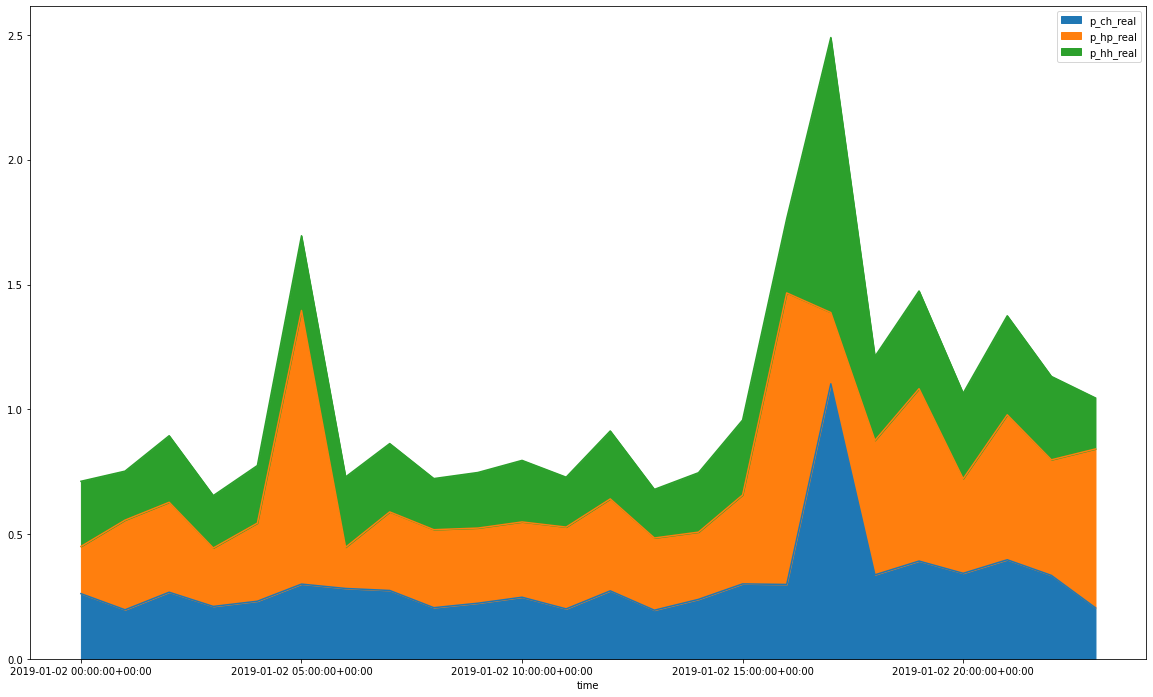

In [64]:
#Plot daily curves for all loads in the household before opt
temp_results[["p_ch_real","p_hp_real","p_hh_real"]].iloc[24:48].plot.area(figsize=(20,12))

<AxesSubplot: xlabel='time'>

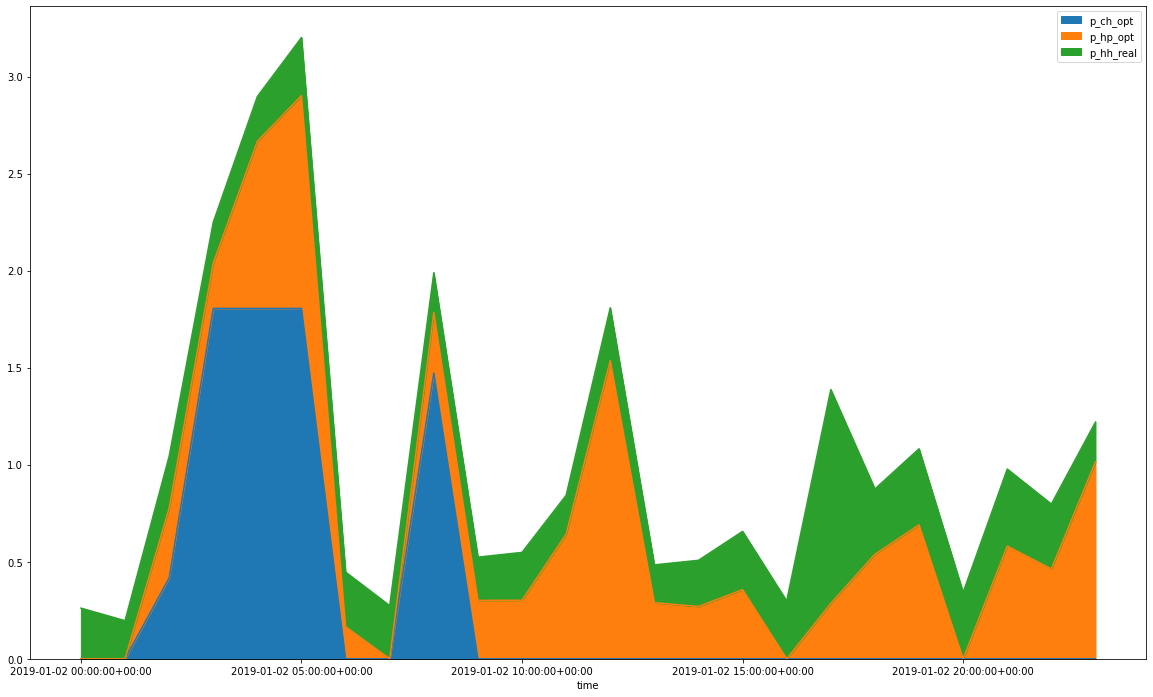

In [65]:
#Plot daily curves for all loads in the household
temp_results[["p_ch_opt","p_hp_opt","p_hh_real"]].iloc[24:48].plot.area(figsize=(20,12))

<AxesSubplot: xlabel='time'>

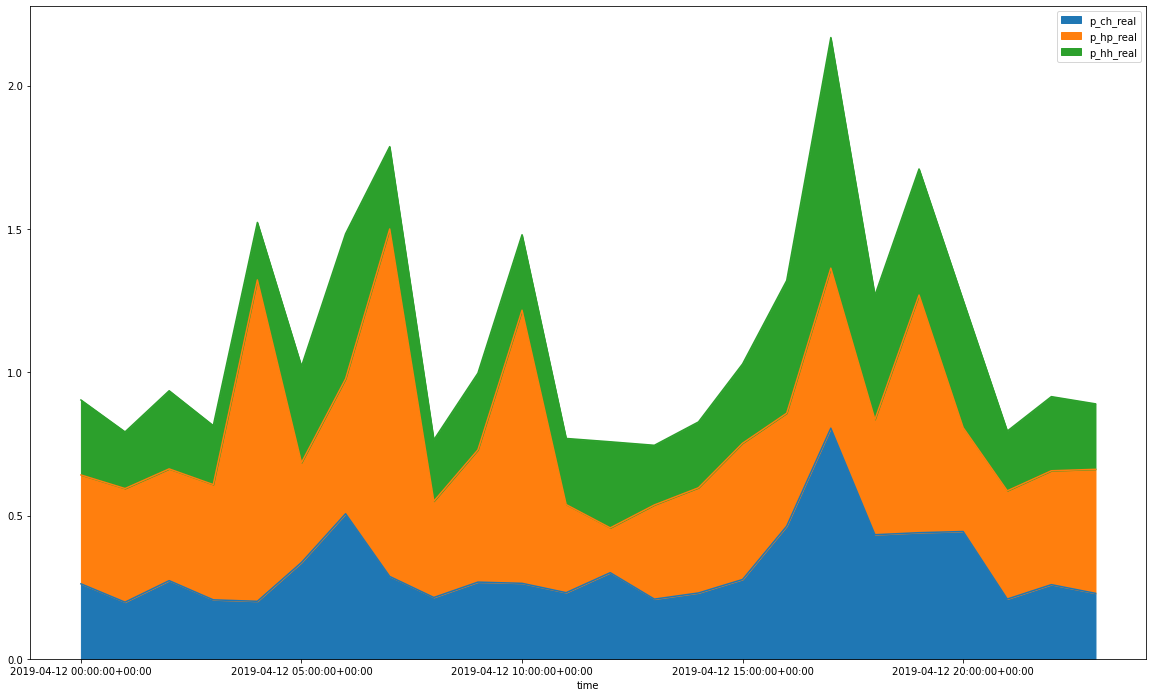

In [66]:
#Plot daily curves for all loads in the household before opt
day = 101
temp_results[["p_ch_real","p_hp_real","p_hh_real"]].iloc[day*24:(day+1)*24].plot.area(figsize=(20,12))

<AxesSubplot: xlabel='time'>

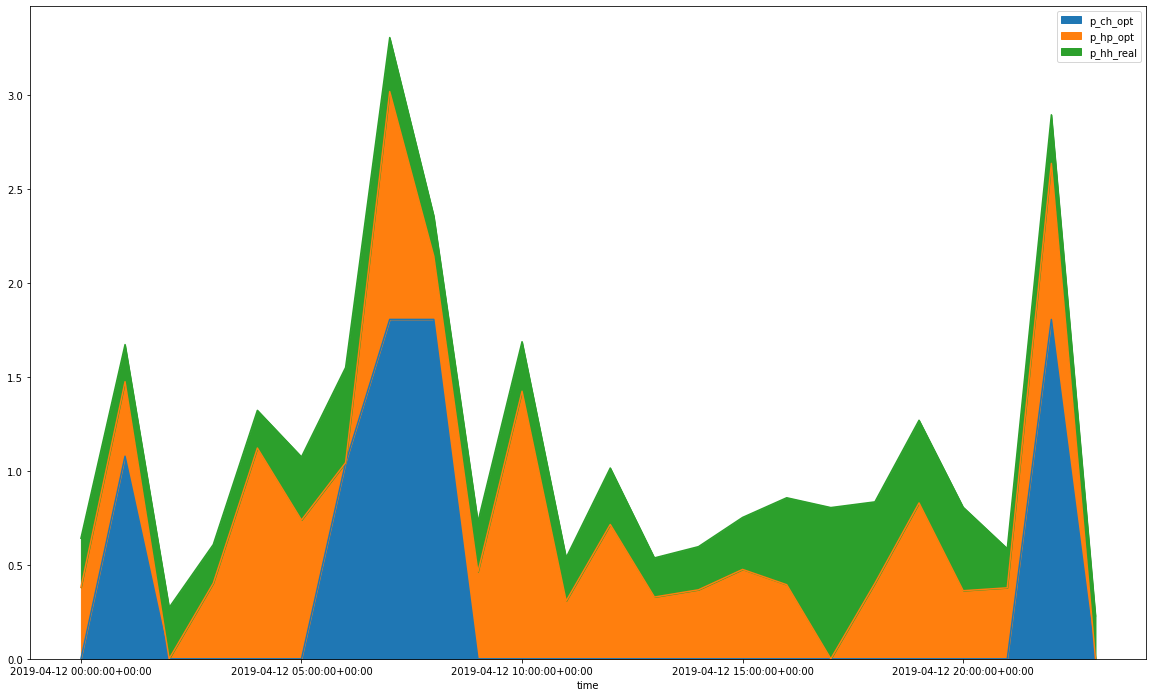

In [67]:
#Plot daily curves for all loads in the household
temp_results[["p_ch_opt","p_hp_opt","p_hh_real"]].iloc[day*24:(day+1)*24].plot.area(figsize=(20,12))

<AxesSubplot: xlabel='time'>

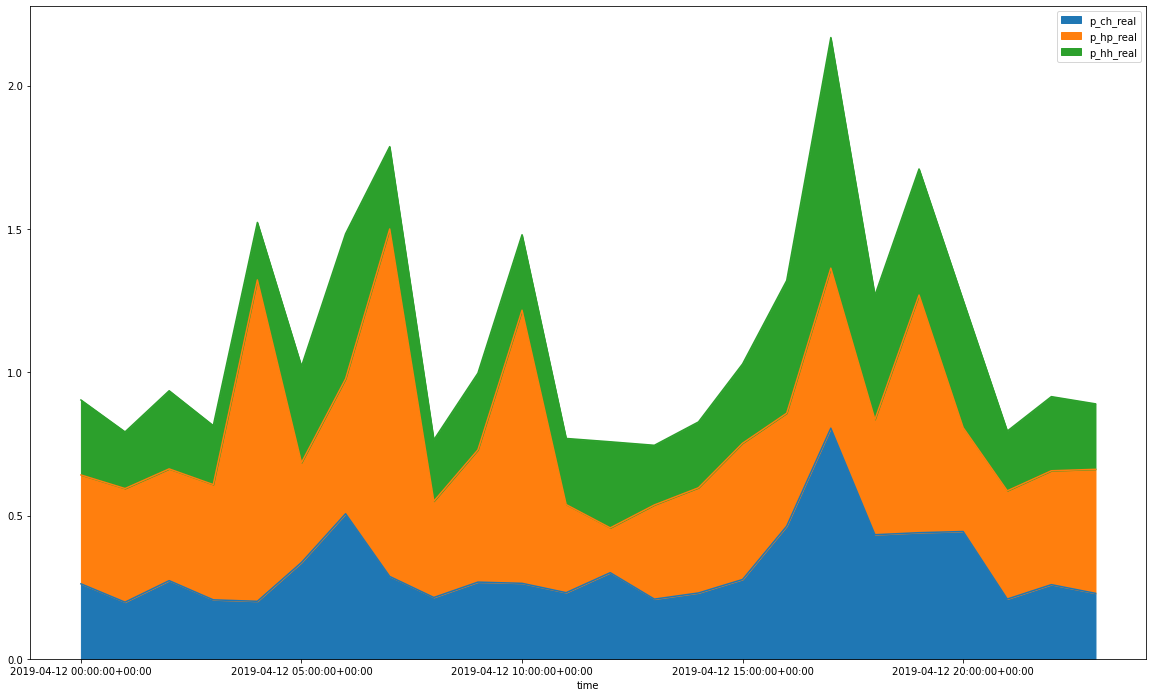

In [68]:
temp_results[["p_ch_real","p_hp_real","p_hh_real"]].iloc[day*24:(day+1)*24].plot.area(figsize=(20,12))

<AxesSubplot: xlabel='time'>

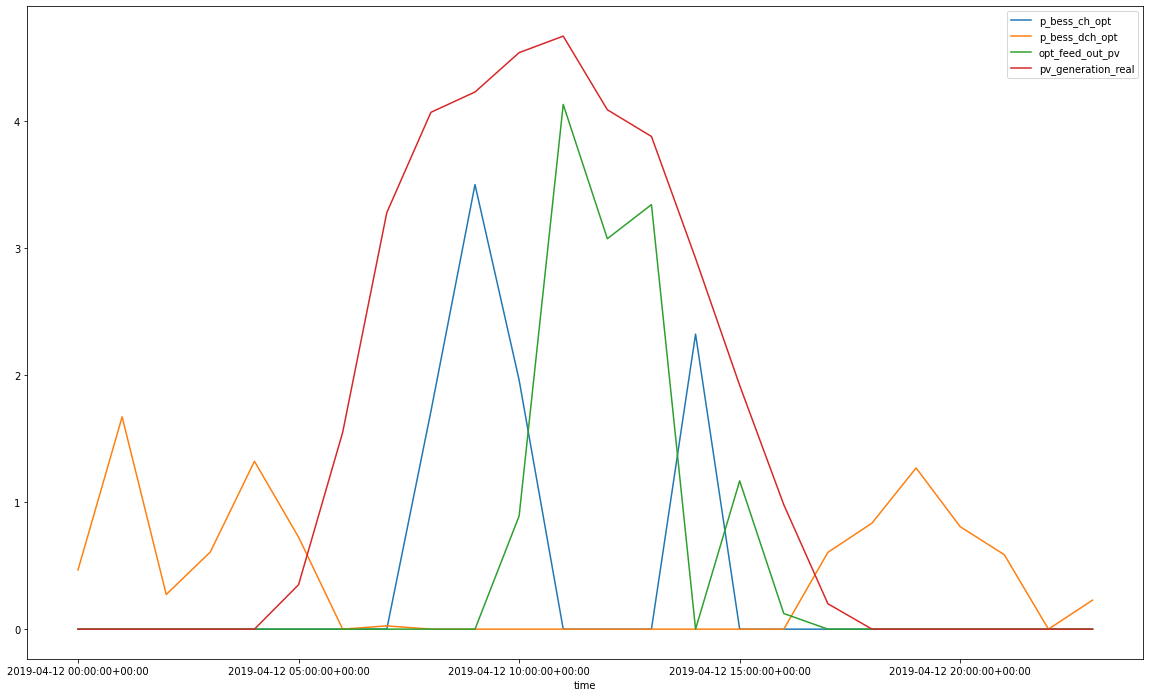

In [69]:
temp_results[["p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","pv_generation_real"]].iloc[day*24:(day+1)*24].plot(figsize=(20,12))


In [17]:
# Plot daily curve for shifting

In [38]:
import unittest
class TestUrl(unittest.TestCase):
    def test_hp_load(self): # Optimum Heat Pump Load should at least equal real load - it can be larger in some cases through the "within hour block" shifting constraint
        for idx_day in range(int(temp_results.shape[0]/24)):
            tolerance = 0.25
            hp_load_real_sum = temp_results["p_hp_real"].iloc[idx_day*24:(idx_day+1)*24].sum()-tolerance
            hp_load_opt_sum = temp_results["p_hp_opt"].iloc[idx_day*24:(idx_day+1)*24].sum()
            self.assertGreater(hp_load_opt_sum,hp_load_real_sum)
    def test_pv_generation(self): # PV feed out should be smaller than actual generation per day
        for idx_day in range(int(temp_results.shape[0]/24)):
            pv_production_real = temp_results["pv_generation_real"].iloc[idx_day*24:(idx_day+1)*24].sum()
            pv_feed_out_opt = temp_results["opt_feed_out_pv"].iloc[idx_day*24:(idx_day+1)*24].sum()
            self.assertGreater(pv_production_real,pv_feed_out_opt)
    def test_daily_ev_generations(self): # Empirical heat pump load should be smaller than optimized EV load
        for idx_day in range(int(temp_results.shape[0]/24)):
            tolerance = 0.25
            ev_load_real = temp_results["p_ch_real"].iloc[idx_day*24:(idx_day+1)*24].sum()-tolerance
            ev_load_opt = temp_results["p_ch_opt"].iloc[idx_day*24:(idx_day+1)*24].sum()
            self.assertGreater(ev_load_opt,ev_load_real)
        
        
res = unittest.main(argv=[''], verbosity=3, exit=False)
# if we want our notebook to stop processing due to failures, we need a cell itself to fail
assert len(res.result.failures) == 0

test_daily_ev_generations (__main__.TestUrl) ... ok
test_hp_load (__main__.TestUrl) ... ok
test_pv_generation (__main__.TestUrl) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.140s

OK


In [28]:
temp_results

,opt_net_energy,energy_costs,p_ch_opt,p_hp_opt,blocked_heatpump,p_bess_ch_opt,p_bess_dch_opt,opt_feed_out_pv,e_bess,p_hh_real,p_ch_real,p_hp_real
time,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.293175,0.035143,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.293175,0.293175,0.404594
2019-01-01 01:00:00+00:00,0.2515,0.029473,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.251500,0.251500,0.418477
2019-01-01 02:00:00+00:00,1.299915,0.147774,0.0,1.115156,0.0,0.0,0.0,0.0,0.5,0.184758,0.184758,1.115156
2019-01-01 03:00:00+00:00,0.60265,0.067449,0.0,0.291944,-0.0,0.0,0.0,0.0,0.5,0.310707,0.310707,0.291944
2019-01-01 04:00:00+00:00,2.447822,0.267767,1.805885,0.40916,-0.0,0.0,0.0,0.0,0.5,0.232777,0.232777,0.409160
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,0.0,0.0,0.0,0.683374,0.0,0.0,1.11114,0.0,1.61114,0.427766,0.427766,0.683374
2019-12-31 20:00:00+00:00,0.962058,0.066555,0.0,0.62744,-0.0,0.0,0.0,0.0,0.5,0.334618,0.334618,0.627440
2019-12-31 21:00:00+00:00,0.817888,0.0565,0.0,0.590793,-0.0,0.0,0.0,0.0,0.5,0.227095,0.227095,0.514462
